# Predicting Apartment Prices in Barcelona 2023
## by Eixample Team


### Set Up

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import seaborn as sns
import os
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score


## 1. Dataset Exploration

In [2]:
# Retrieve path and load the data
path = os.getcwd()
df = pd.read_csv(path+"/train.csv")
df_test = pd.read_csv(path+"/test.csv")
df_test.head(3)

,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets
0,6253,NaN,1.0,152.0,NaN,2012.0,5º - 4a,True,True,Les Cors,0.0,False,False,NaN
1,4685,NaN,2.0,90.0,east,1957.0,10º - 1a,True,False,Ciutat Vella,2.0,False,True,3.0
2,1732,NaN,2.0,86.0,NaN,1991.0,5º - 2a,False,False,Eixample,0.0,False,True,NaN


In [3]:
# Types of the variables and number of non NaN
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8000 non-null   int64  
 1   num_rooms         8000 non-null   float64
 2   num_baths         7840 non-null   float64
 3   square_meters     7845 non-null   float64
 4   orientation       5659 non-null   object 
 5   year_built        7830 non-null   float64
 6   door              7851 non-null   object 
 7   is_furnished      7835 non-null   object 
 8   has_pool          7844 non-null   object 
 9   neighborhood      7835 non-null   object 
 10  num_crimes        7840 non-null   float64
 11  has_ac            7831 non-null   object 
 12  accepts_pets      7845 non-null   object 
 13  num_supermarkets  1411 non-null   float64
 14  price             8000 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 937.6+ KB


In [4]:
# Number of rows and columns
df.shape

(8000, 15)

In [5]:
# Descriptive statistics of the data
df.describe()

,id,num_rooms,num_baths,square_meters,year_built,num_crimes,num_supermarkets,price
count,8000.000000,8000.000000,7840.000000,7845.000000,7830.000000,7840.000000,1411.000000,8000.000000
mean,5012.506875,2.868500,1.988265,108.031995,1985.321073,2.803444,1.982991,1099.616250
std,2887.649416,5.300469,0.815943,38.671420,20.591437,3.447714,0.803182,271.686617
min,2.000000,1.000000,1.000000,-100.000000,1950.000000,0.000000,1.000000,195.000000
25%,2512.750000,1.000000,1.000000,78.000000,1968.000000,0.000000,1.000000,905.750000
50%,5014.500000,2.000000,2.000000,110.000000,1985.000000,1.000000,2.000000,1104.000000
75%,7505.250000,4.000000,3.000000,140.000000,2003.000000,6.000000,3.000000,1295.000000
max,10000.000000,97.000000,3.000000,170.000000,2021.000000,10.000000,3.000000,2095.000000


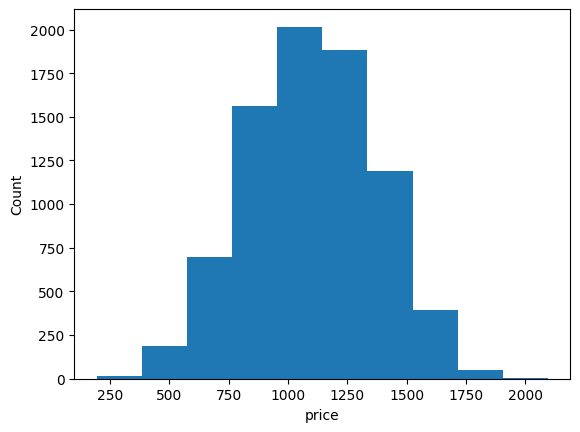

In [6]:
# Distribution of the target variable
plt.hist(df['price'], bins=10)
plt.xlabel('price')
plt.ylabel('Count')
plt.show()

### Correlation amongst quantitative variables

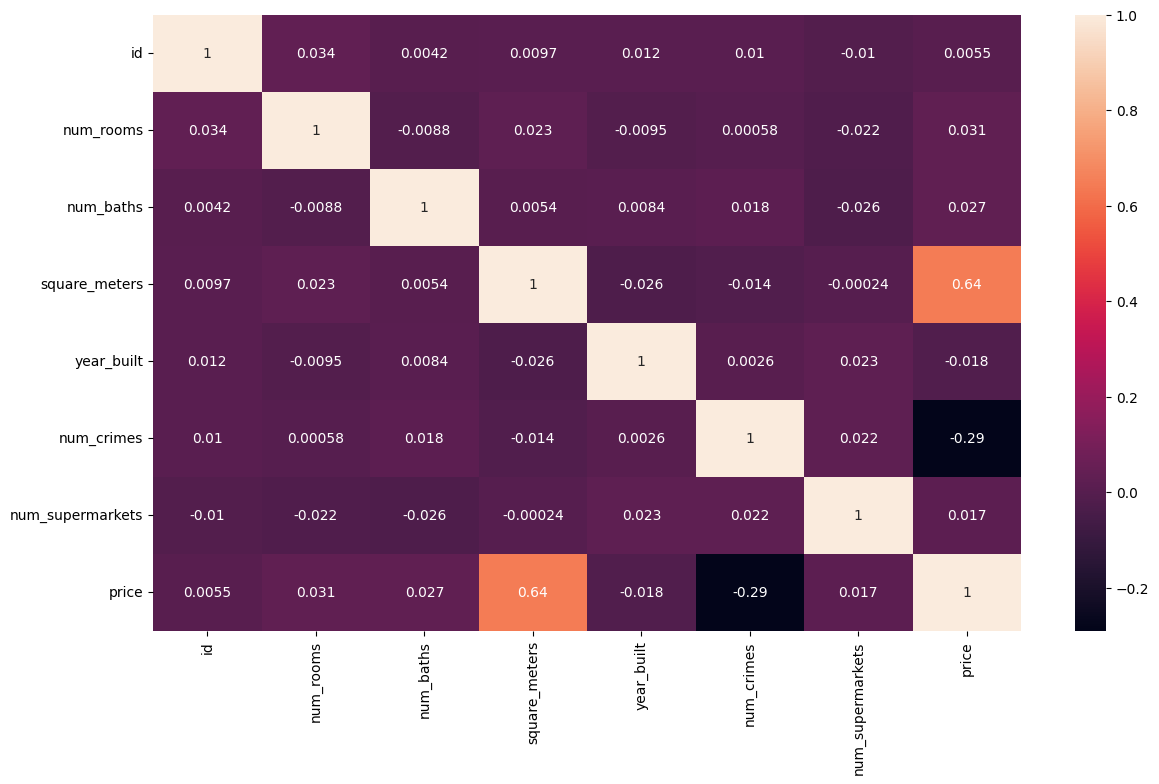

In [7]:
# Correlations among the variables 
df_for_heatmap = df.drop(columns=['door', 'orientation', 'neighborhood', 'is_furnished', 'has_pool', 'has_ac', 'accepts_pets'])
df_for_heatmap_corr = df_for_heatmap.corr()

# Plot correlations
fig, ax = plt.subplots(figsize=(14,8))
ax = sns.heatmap(df_for_heatmap_corr, annot = True)

## 2. Handling Missing Data and Categorical Variables

In [8]:
# Function to create table of missing values
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

                # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
# Check the NAs
print(missing_values_table(df))
print()
print(missing_values_table(df_test))

Your selected dataframe has 15 columns.
There are 12 columns that have missing values.
                  Missing Values  % of Total Values
num_supermarkets            6589               82.4
orientation                 2341               29.3
year_built                   170                2.1
has_ac                       169                2.1
is_furnished                 165                2.1
neighborhood                 165                2.1
num_baths                    160                2.0
num_crimes                   160                2.0
has_pool                     156                2.0
square_meters                155                1.9
accepts_pets                 155                1.9
door                         149                1.9

Your selected dataframe has 14 columns.
There are 13 columns that have missing values.
                  Missing Values  % of Total Values
num_supermarkets            1626               81.3
orientation                  523             

<Axes: >

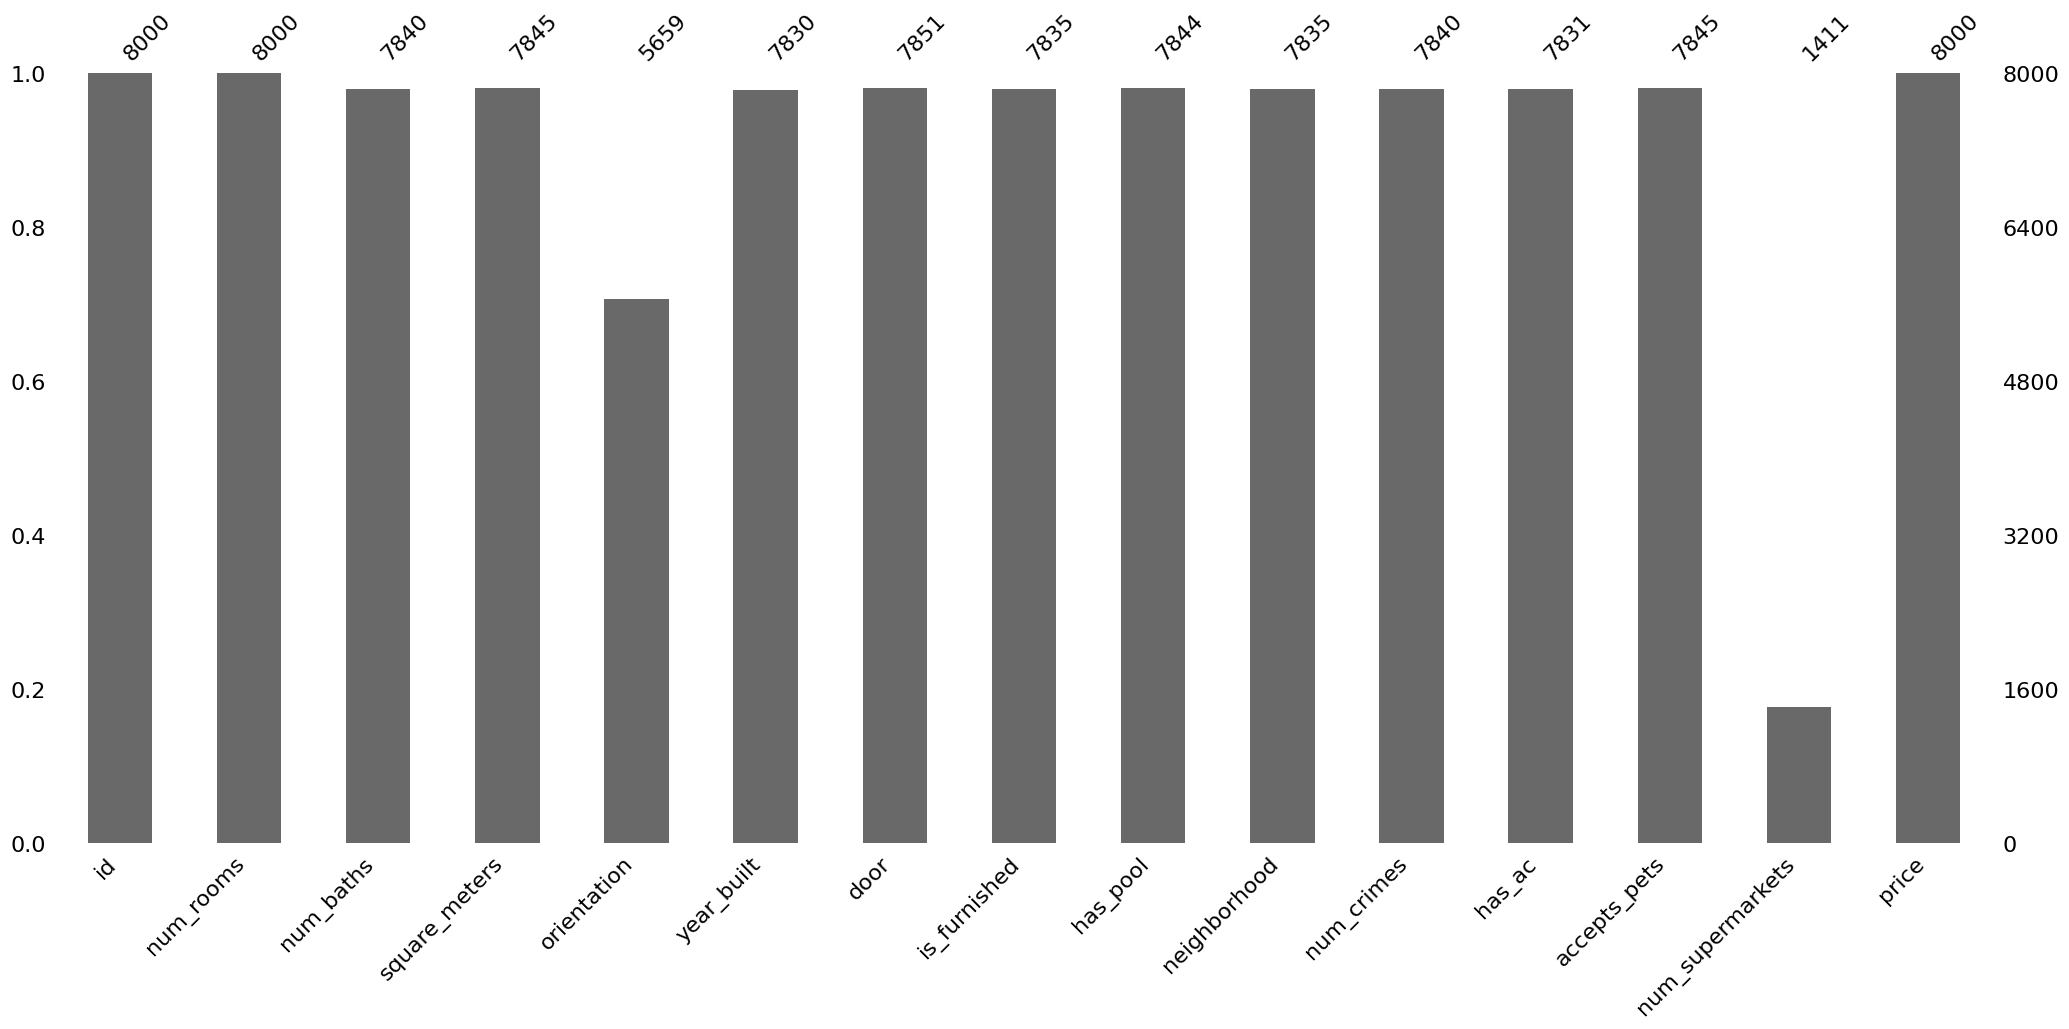

In [10]:
# NaNs distibution along the variables
msno.bar(df)

<Axes: >

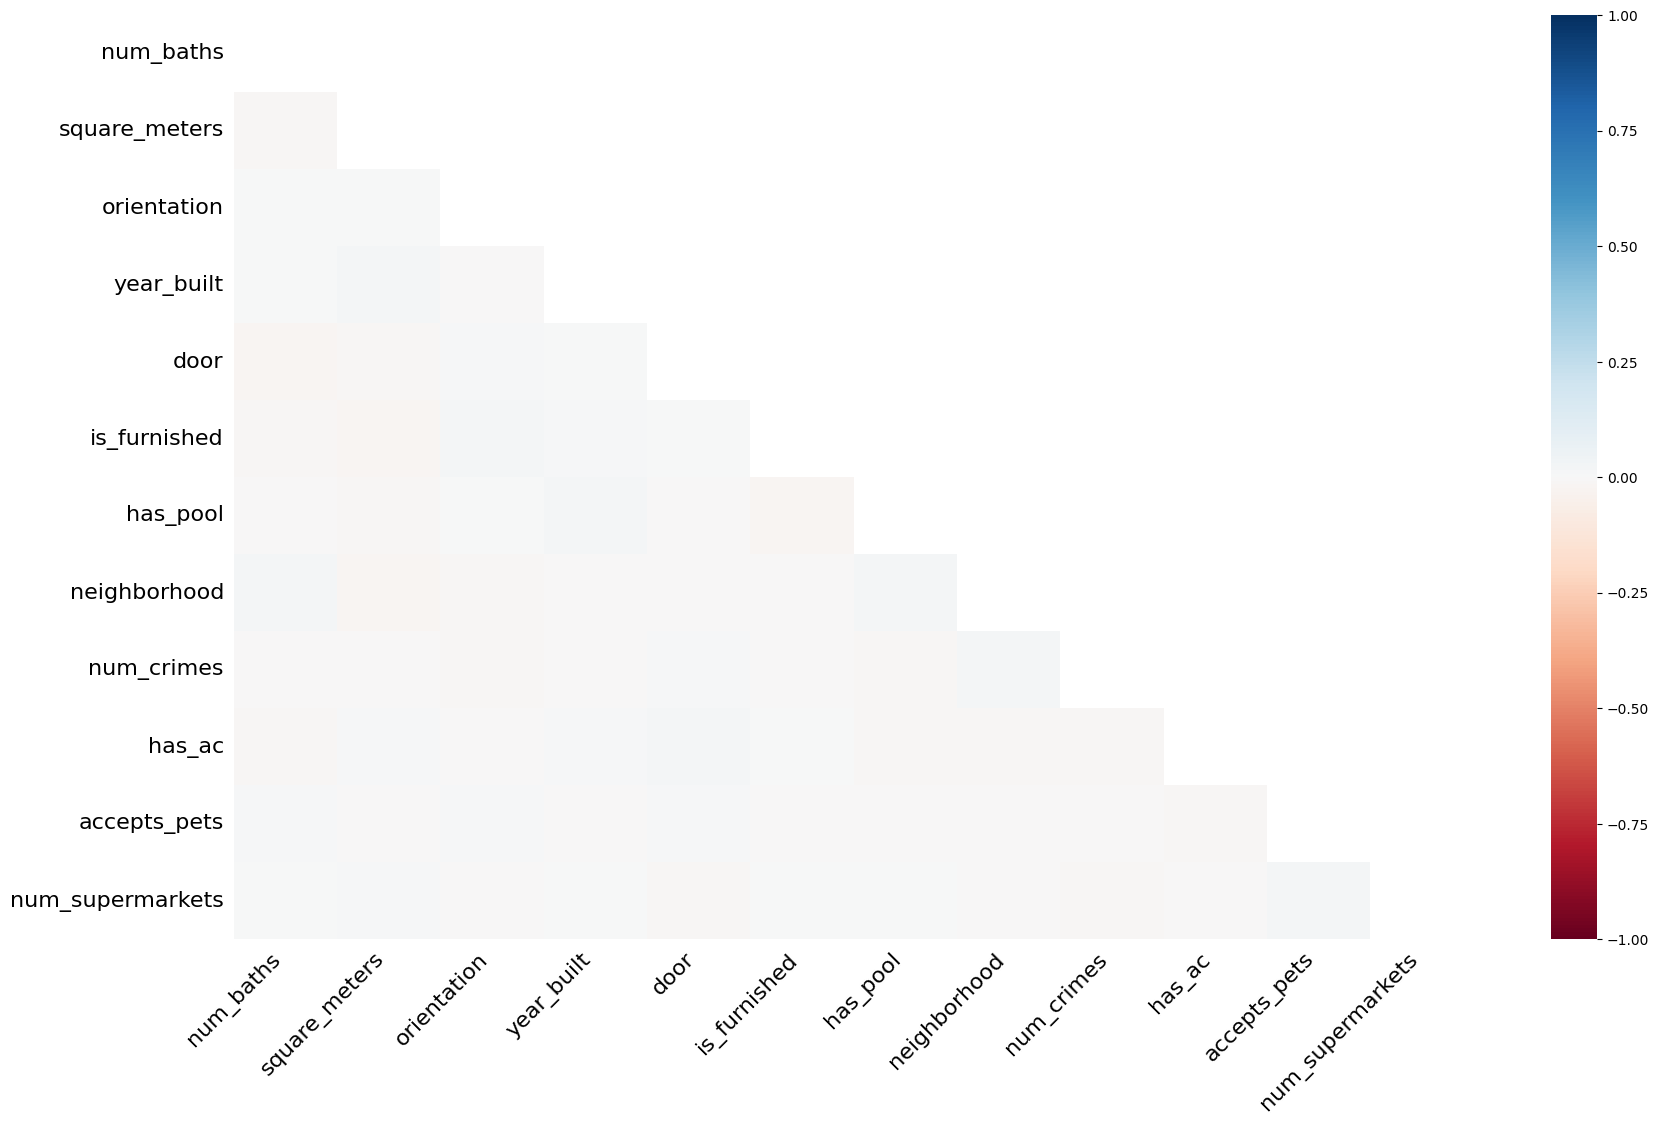

In [11]:
# Check, if there are correlations among NaNs
msno.heatmap(df)

In [12]:
# Dealing with NA:
# orientation - one hot encoding and KNN then
# num_baths, square_meters - KNN - doesn't really work well, probably because correlation is low, so i imputed mean by the group num_room
# year_built - mean bygroup neighbourhood
# door - 0 as constant
# is_furnished - KNN
# has_pool - KNN
# num_crimes, num_supermarkets - KNN didn't work well, so i imputed mean by the group neighbourhood first
# has_ac - KNN
# accepts_pets - KNN
# neighborhood - one hot encoding + ?

In [13]:
# Function to calculate mean for the groups
def mean_group(df, column_groupby, columns_to_impute):
    groupby_mean = df.groupby(column_groupby)[columns_to_impute].transform('mean')
    df[columns_to_impute] = df[columns_to_impute].fillna(groupby_mean)
    return df #, groupby_mean

def mean_group_test(df, columns_to_impute, groupby_mean):
    df[columns_to_impute] = df[columns_to_impute].fillna(groupby_mean)
    return df

In [14]:
# Call the function to impute means grouped by neighbourhood
df = mean_group(df, 'neighborhood', ['year_built', 'num_supermarkets', 'num_crimes'])
df_test = mean_group(df_test, 'neighborhood', ['year_built', 'num_supermarkets', 'num_crimes'])
print(df_test.isna().sum())

id                    0
num_rooms           191
num_baths            40
square_meters        43
orientation         523
year_built            0
door                 51
is_furnished         35
has_pool             44
neighborhood         35
num_crimes            0
has_ac               31
accepts_pets         45
num_supermarkets     32
dtype: int64


In [15]:
# Call the function to impute means grouped by num_rooms 
df = mean_group(df, 'num_rooms', ['num_baths', 'square_meters'])
df_test = mean_group(df_test, 'num_rooms', ['num_baths', 'square_meters'])

print(df_test.isna().sum())

id                    0
num_rooms           191
num_baths             5
square_meters         6
orientation         523
year_built            0
door                 51
is_furnished         35
has_pool             44
neighborhood         35
num_crimes            0
has_ac               31
accepts_pets         45
num_supermarkets     32
dtype: int64


In [16]:
# What are the unique values in orientation
df['orientation'] = df['orientation'].replace('soxth', 'south')
df_test['orientation'] = df_test['orientation'].replace('soxth', 'south')
unique_values = df['orientation'].unique()
print(unique_values)
# What are the unique values in neighborhood
unique_values = df['neighborhood'].unique()
print(unique_values)

[nan 'west' 'east' 'north' 'south']
['Sant Martí' 'Sants' 'Eixample' 'Gràcia' nan 'Les Cors'
 'Sarrià-Sant Gervasi' 'Horta' 'Sant Andreu' 'Ciutat Vella' 'Nou Barris']


In [17]:
# Function to create dummies, do it in the part of dealing with NA to use these columns for KNN as the next step
def encode(df, columns_hot):
    encoded_df = pd.get_dummies(df, columns=columns_hot, dtype=float)
    return encoded_df

In [18]:
# Execute function for df and df_test
df = encode(df, ['orientation', 'neighborhood'])
df_test = encode(df_test, ['orientation', 'neighborhood'])
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                2000 non-null   int64  
 1   num_rooms                         1809 non-null   float64
 2   num_baths                         1995 non-null   float64
 3   square_meters                     1994 non-null   float64
 4   year_built                        2000 non-null   float64
 5   door                              1949 non-null   object 
 6   is_furnished                      1965 non-null   object 
 7   has_pool                          1956 non-null   object 
 8   num_crimes                        2000 non-null   float64
 9   has_ac                            1969 non-null   object 
 10  accepts_pets                      1955 non-null   object 
 11  num_supermarkets                  1968 non-null   float64
 12  orient

In [19]:
# Impute missing values with a constant (e.g., 0)
df['door'].fillna(0, inplace=True)
df_test['door'].fillna(0, inplace=True)
print(df_test.isna().sum())

id                                    0
num_rooms                           191
num_baths                             5
square_meters                         6
year_built                            0
door                                  0
is_furnished                         35
has_pool                             44
num_crimes                            0
has_ac                               31
accepts_pets                         45
num_supermarkets                     32
orientation_east                      0
orientation_north                     0
orientation_south                     0
orientation_west                      0
neighborhood_Ciutat Vella             0
neighborhood_Eixample                 0
neighborhood_Gràcia                   0
neighborhood_Horta                    0
neighborhood_Les Cors                 0
neighborhood_Nou Barris               0
neighborhood_Sant Andreu              0
neighborhood_Sant Martí               0
neighborhood_Sants                    0


In [20]:
# Create features in order to use these columns for KNN as the next step
# Split the 'door' column into 'floor' and 'apartment' columns
df[['floor', 'apartment']] = df['door'].str.split(' - ', expand=True)
df_test[['floor', 'apartment']] = df_test['door'].str.split(' - ', expand=True)

# Remove any non-numeric characters from the 'apartment' column
df['apartment'] = df['apartment'].str.extract('(\d+)')
df_test['apartment'] = df_test['apartment'].str.extract('(\d+)')

# Remove '^0' from the 'floor' column
df['floor'] = df['floor'].str.replace('º', '', regex=True)
df_test['floor'] = df_test['floor'].str.replace('º', '', regex=True)

# Drop the 'door' column
df.drop(columns=['door'], inplace=True)
df_test.drop(columns=['door'], inplace=True)

# Print the updated DataFrame
df_test.head()

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,...,neighborhood_Gràcia,neighborhood_Horta,neighborhood_Les Cors,neighborhood_Nou Barris,neighborhood_Sant Andreu,neighborhood_Sant Martí,neighborhood_Sants,neighborhood_Sarrià-Sant Gervasi,floor,apartment
0,6253,NaN,1.0,152.0,2012.0,True,True,0.0,False,False,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,5,4
1,4685,NaN,2.0,90.0,1957.0,True,False,2.0,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,1
2,1732,NaN,2.0,86.0,1991.0,False,False,0.0,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,2
3,4743,NaN,3.0,164.0,2002.0,False,True,7.0,False,False,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,8,4
4,4522,NaN,1.0,99.0,1984.0,True,True,0.0,True,False,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8,4


In [21]:
# Check unique values for the floor
unique_floor_values = df['floor'].unique()
print(unique_floor_values)

['3' '7' '1' '6' '5' '10' nan '2' '8' '4' '9']


In [22]:
# Check the NA left
#print(df.isna().sum())
df_test.isna().sum()

id                                    0
num_rooms                           191
num_baths                             5
square_meters                         6
year_built                            0
is_furnished                         35
has_pool                             44
num_crimes                            0
has_ac                               31
accepts_pets                         45
num_supermarkets                     32
orientation_east                      0
orientation_north                     0
orientation_south                     0
orientation_west                      0
neighborhood_Ciutat Vella             0
neighborhood_Eixample                 0
neighborhood_Gràcia                   0
neighborhood_Horta                    0
neighborhood_Les Cors                 0
neighborhood_Nou Barris               0
neighborhood_Sant Andreu              0
neighborhood_Sant Martí               0
neighborhood_Sants                    0
neighborhood_Sarrià-Sant Gervasi      0


In [23]:
# Impute NAs left with KNN

# Specify the columns to impute
columns_to_impute = ['num_rooms', 'num_baths', 'year_built', 'square_meters', 'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets', 'num_supermarkets', 'floor', 'apartment']

# Create a KNNImputer object with k=3 (or another suitable value)
imputer = KNNImputer(n_neighbors=3)

# Perform KNN imputation only on the specified columns for the training data
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

# Perform KNN imputation on the same columns for the test data (use the same imputer)
df_test[columns_to_impute] = imputer.transform(df_test[columns_to_impute])

In [24]:
# Check if data is clean
df_test.isna().sum()

id                                  0
num_rooms                           0
num_baths                           0
square_meters                       0
year_built                          0
is_furnished                        0
has_pool                            0
num_crimes                          0
has_ac                              0
accepts_pets                        0
num_supermarkets                    0
orientation_east                    0
orientation_north                   0
orientation_south                   0
orientation_west                    0
neighborhood_Ciutat Vella           0
neighborhood_Eixample               0
neighborhood_Gràcia                 0
neighborhood_Horta                  0
neighborhood_Les Cors               0
neighborhood_Nou Barris             0
neighborhood_Sant Andreu            0
neighborhood_Sant Martí             0
neighborhood_Sants                  0
neighborhood_Sarrià-Sant Gervasi    0
floor                               0
apartment   

In [25]:
# Check if the shape didn't change
print(df.shape)
print(df_test.shape)

(8000, 28)
(2000, 27)


## Addressing Categorical Features and Outliers

In [26]:
# Look at unique values of square_meters - there are negative numbers
df.square_meters.unique()

array([ 107.4186747 ,  133.        ,  137.        ,  -41.        ,
         70.        ,   77.        ,  170.        ,  117.        ,
         59.        ,   52.        ,  101.        ,  115.        ,
        152.        ,  161.        ,  154.        ,   57.        ,
        134.        ,  167.        ,   62.        ,  163.        ,
        118.        ,   83.        ,  160.        ,   89.        ,
        108.2954071 ,  135.        ,  125.        ,   60.        ,
        149.        ,  138.        ,  128.        ,  162.        ,
        104.        ,  169.        ,  131.        ,  166.        ,
         88.        ,  105.        ,   73.        ,  158.        ,
        107.        ,  111.        ,   86.        ,   68.        ,
        164.        ,  121.        ,   64.        ,  156.        ,
        102.        ,   66.        ,  168.        ,   61.        ,
        143.        ,  109.        ,   54.        ,  119.        ,
        108.        ,   74.        ,   90.        ,  153.     

In [27]:
# We can see that some values match the amount of rooms and possible square meters (but not all of them actially - will work on those later). 
df[(df['square_meters'] < 0) & (df['num_rooms'] >= 0)]

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,...,neighborhood_Gràcia,neighborhood_Horta,neighborhood_Les Cors,neighborhood_Nou Barris,neighborhood_Sant Andreu,neighborhood_Sant Martí,neighborhood_Sants,neighborhood_Sarrià-Sant Gervasi,floor,apartment
3,6088,1.0,2.000000,-41.0,2002.0,0.0,1.000000,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,6.0,1.0
126,5226,4.0,1.000000,-15.0,1984.0,1.0,0.666667,2.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,2.0
129,1053,3.0,3.000000,-97.0,2000.0,1.0,1.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
156,3729,3.0,1.000000,-78.0,2009.0,0.0,0.000000,6.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,2.0
169,6815,1.0,3.000000,-36.0,1966.0,1.0,0.000000,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7665,7344,4.0,1.977296,-68.0,1957.0,0.0,0.333333,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0
7688,6103,1.0,2.000000,-72.0,1976.0,1.0,0.000000,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0
7833,3305,2.0,1.000000,-11.0,1993.0,0.0,0.000000,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,3.0
7916,5277,1.0,1.000000,-73.0,2001.0,0.0,1.000000,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0


In [28]:
# Remove the minuses in the column square_meters
df['square_meters'] = df['square_meters'].abs()
df_test['square_meters'] = df_test['square_meters'].abs()

In [29]:
# Run a check
df[(df['square_meters'] < 0) & (df['num_rooms'] >= 0)]

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,...,neighborhood_Gràcia,neighborhood_Horta,neighborhood_Les Cors,neighborhood_Nou Barris,neighborhood_Sant Andreu,neighborhood_Sant Martí,neighborhood_Sants,neighborhood_Sarrià-Sant Gervasi,floor,apartment


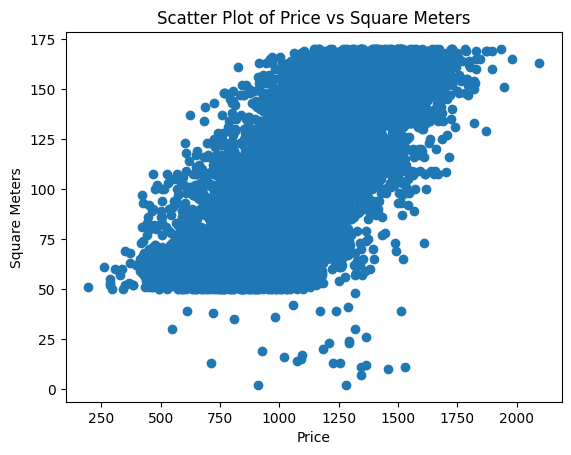

In [30]:
# Create a scatter plot to see, if there are strange values
plt.scatter(df['price'], df['square_meters'])
plt.xlabel('Price')
plt.ylabel('Square Meters')
plt.title('Scatter Plot of Price vs Square Meters')
plt.show()

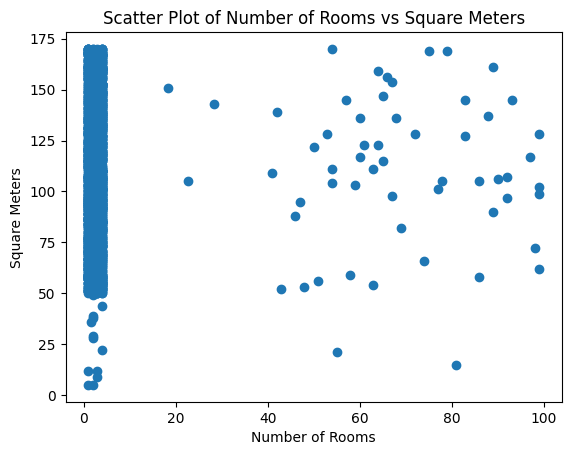

In [31]:
# Create a scatter plot to see, if there are strange values
plt.scatter(df_test['num_rooms'], df_test['square_meters'])
plt.xlabel('Number of Rooms')
plt.ylabel('Square Meters')
plt.title('Scatter Plot of Number of Rooms vs Square Meters')
plt.show()

In [32]:
# Number of strange values having viewd the box plot. 
count_small = len(df_test[df_test['square_meters'] < 50])
count = len(df_test['square_meters'])
print(count)
print(count_small)
print((count_small/count)*100)

2000
15
0.75


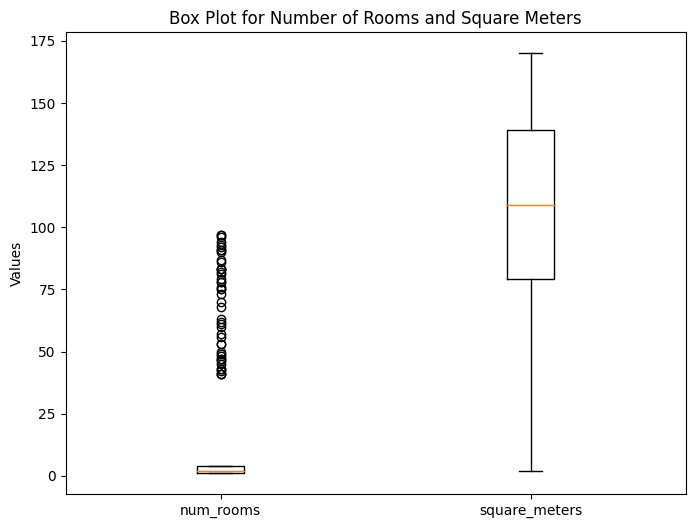

In [33]:
# Create a box plot for num_rooms and square_meters
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
plt.boxplot([df['num_rooms'], df['square_meters']], labels=['num_rooms', 'square_meters'])
plt.ylabel('Values')
plt.title('Box Plot for Number of Rooms and Square Meters')
plt.show()

In [34]:
# Calculate the median square_meters grouped by num_rooms
mean_square_meters = df.groupby('num_rooms')['square_meters'].transform('median')
mean_square_meters_test = df_test.groupby('num_rooms')['square_meters'].transform('median')

# Replace values less than 50 with the corresponding mean_square_meters
df['square_meters'] = df.apply(lambda row: mean_square_meters[round(row['num_rooms'])] if row['square_meters'] < 50 else row['square_meters'], axis=1)
df_test['square_meters'] = df_test.apply(lambda row: mean_square_meters_test[round(row['num_rooms'])] if row['square_meters'] < 50 else row['square_meters'], axis=1)

# Number of outliers having viewed the box plot.
count_small = len(df_test[df_test['square_meters'] < 50])
print(count_small)

0


In [35]:
# Number of outliers having viewd the box plot. 
count = len(df_test[df_test['num_rooms'] > 25])
count

55

In [36]:
# Winsorize na in the column num_rooms

# Calculate the 1st and 99th percentiles
first_percentile = df['num_rooms'].quantile(0.01)
ninety_ninth_percentile = df['num_rooms'].quantile(0.99)

# Windsorize the 'num_rooms' column
df['num_rooms'] = df['num_rooms'].apply(lambda x: first_percentile if x < first_percentile else (ninety_ninth_percentile if x > ninety_ninth_percentile else x))
df_test['num_rooms'] = df_test['num_rooms'].apply(lambda x: first_percentile if x < first_percentile else (ninety_ninth_percentile if x > ninety_ninth_percentile else x))


In [37]:
# Number of outliers having viewd the box plot. 
count = len(df_test[df_test['num_rooms'] > 25])
count

0

In [38]:
df_test.describe()

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,num_crimes,has_ac,accepts_pets,...,neighborhood_Gràcia,neighborhood_Horta,neighborhood_Les Cors,neighborhood_Nou Barris,neighborhood_Sant Andreu,neighborhood_Sant Martí,neighborhood_Sants,neighborhood_Sarrià-Sant Gervasi,floor,apartment
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,...,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,4952.472500,2.551333,2.007664,109.718263,1985.505349,0.497667,0.479333,2.673496,0.503833,0.505500,...,0.094000,0.100000,0.085000,0.104500,0.098000,0.111000,0.093000,0.094500,5.608167,2.457500
std,2884.100313,1.097507,0.805359,34.287744,20.548918,0.497222,0.496797,3.362847,0.497659,0.496413,...,0.291902,0.300075,0.278951,0.305985,0.297389,0.314211,0.290505,0.292596,2.879506,1.106659
min,1.000000,1.000000,1.000000,50.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2463.500000,2.000000,1.000000,81.000000,1969.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000
50%,4950.500000,3.000000,2.000000,108.635104,1986.000000,0.333333,0.000000,0.000000,0.666667,0.666667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2.000000
75%,7488.250000,3.750000,3.000000,139.000000,2003.000000,1.000000,1.000000,5.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,3.000000
max,9999.000000,4.000000,3.000000,170.000000,2021.000000,1.000000,1.000000,10.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000,4.000000


In [39]:
def standardize(df, columns):
    for column in columns:
        df[column + '_standardized'] = (df[column] - df[column].mean()) / df[column].std()
    
    # Drop the original columns
    df.drop(columns=columns, inplace=True)
    
    return df

columns_to_standardize = ['num_rooms', 'num_baths', 'square_meters', 'year_built', 'num_crimes', 'num_supermarkets']
df = standardize(df, columns_to_standardize)
df_test = standardize(df_test, columns_to_standardize)
df.head()

,id,is_furnished,has_pool,has_ac,accepts_pets,price,orientation_east,orientation_north,orientation_south,orientation_west,...,neighborhood_Sants,neighborhood_Sarrià-Sant Gervasi,floor,apartment,num_rooms_standardized,num_baths_standardized,square_meters_standardized,year_built_standardized,num_crimes_standardized,num_supermarkets_standardized
0,9255,0.0,0.0,1.0,1.0,1096,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,1.0,-1.332816,-1.223443,-0.059467,-1.439220,-0.234568,0.168456
1,1562,0.0,0.0,0.0,0.0,1396,0.0,0.0,0.0,1.0,...,1.0,0.0,7.0,2.0,1.335929,-1.223443,0.680094,-1.242878,0.350427,0.061836
2,1671,0.0,1.0,0.0,0.0,1263,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,-0.443234,1.252568,0.795734,0.720545,-0.819562,-0.022842
3,6088,0.0,1.0,0.0,0.0,1290,0.0,0.0,0.0,0.0,...,1.0,0.0,6.0,1.0,-1.332816,0.014563,0.000705,0.818716,0.642924,0.194626
4,6670,1.0,0.0,0.0,1.0,962,0.0,0.0,0.0,0.0,...,0.0,0.0,5.0,1.0,-0.443234,-1.223443,-1.141247,-0.310252,-0.819562,2.983215


In [40]:
df.describe()

,id,is_furnished,has_pool,has_ac,accepts_pets,price,orientation_east,orientation_north,orientation_south,orientation_west,...,neighborhood_Sants,neighborhood_Sarrià-Sant Gervasi,floor,apartment,num_rooms_standardized,num_baths_standardized,square_meters_standardized,year_built_standardized,num_crimes_standardized,num_supermarkets_standardized
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8.000000e+03
mean,5012.506875,0.481542,0.504000,0.504500,0.508167,1099.616250,0.175125,0.177250,0.172375,0.182625,...,0.102875,0.095125,5.587125,2.507208,-4.130030e-17,1.989520e-16,8.437695e-17,8.496315e-15,4.529710e-17,1.847411e-16
std,2887.649416,0.496007,0.496782,0.496750,0.497011,271.686617,0.380098,0.381904,0.377730,0.386383,...,0.303815,0.293406,2.826299,1.116589,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,2.000000,0.000000,0.000000,0.000000,0.000000,195.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,-1.332816e+00,-1.223443e+00,-1.719450e+00,-1.733734e+00,-8.195621e-01,-2.859543e+00
25%,2512.750000,0.000000,0.000000,0.000000,0.000000,905.750000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,2.000000,-1.332816e+00,-1.223443e+00,-8.521451e-01,-8.501932e-01,-8.195621e-01,-1.100097e-01
50%,5014.500000,0.000000,0.666667,0.666667,1.000000,1104.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,6.000000,2.666667,-4.432340e-01,1.456264e-02,-1.375024e-02,-1.573846e-02,-5.270649e-01,-2.284150e-02
75%,7505.250000,1.000000,1.000000,1.000000,1.000000,1295.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,8.000000,4.000000,1.335929e+00,1.252568e+00,8.535548e-01,8.678019e-01,6.429238e-01,1.684558e-01
max,10000.000000,1.000000,1.000000,1.000000,1.000000,2095.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,10.000000,4.000000,1.335929e+00,1.252568e+00,1.749770e+00,1.751342e+00,2.105410e+00,2.983215e+00


In [41]:
df_test.isna().sum() # check that there are no more null values

id                                  0
is_furnished                        0
has_pool                            0
has_ac                              0
accepts_pets                        0
orientation_east                    0
orientation_north                   0
orientation_south                   0
orientation_west                    0
neighborhood_Ciutat Vella           0
neighborhood_Eixample               0
neighborhood_Gràcia                 0
neighborhood_Horta                  0
neighborhood_Les Cors               0
neighborhood_Nou Barris             0
neighborhood_Sant Andreu            0
neighborhood_Sant Martí             0
neighborhood_Sants                  0
neighborhood_Sarrià-Sant Gervasi    0
floor                               0
apartment                           0
num_rooms_standardized              0
num_baths_standardized              0
square_meters_standardized          0
year_built_standardized             0
num_crimes_standardized             0
num_supermar

In [43]:
# Calculate the correlations of 'price' with all other columns
correlations = df.corr()['price']

print(correlations)

id                                  0.005516
is_furnished                        0.006594
has_pool                           -0.000141
has_ac                             -0.007530
accepts_pets                       -0.009956
price                               1.000000
orientation_east                   -0.010132
orientation_north                  -0.005406
orientation_south                   0.004248
orientation_west                   -0.001838
neighborhood_Ciutat Vella          -0.004134
neighborhood_Eixample               0.052924
neighborhood_Gràcia                 0.021665
neighborhood_Horta                  0.010224
neighborhood_Les Cors               0.032869
neighborhood_Nou Barris            -0.076136
neighborhood_Sant Andreu           -0.039443
neighborhood_Sant Martí            -0.038180
neighborhood_Sants                 -0.014445
neighborhood_Sarrià-Sant Gervasi    0.062495
floor                               0.102611
apartment                          -0.018775
num_rooms_

In [44]:
# Function to split data
def splitdata(df, target_column):
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    return X_train, X_test, y_train, y_test

In [45]:
# Call the splitdata function
X_train, X_test, y_train, y_test = splitdata(df, 'price')

# Now you can print the values
# print(f'X_train: {X_train}')
# print(f'X_test: {X_test}')
# print(f'y_train: {y_train}')
# print(f'y_test: {y_test}')

In [46]:
# Define the features and target
X_train = X_train
X_test = X_test
y_test = y_test
y_train = y_train

# Train the model
# For Lasso Regression: 
model = Lasso(random_state=42, alpha = 1.5)

model.fit(X_train, y_train)

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Compute metrics
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)

train_r2 = r2_score(y_train, train_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("Train MSE:", train_mse)
print("Test MSE:", test_mse)
print("Train R^2:", train_r2)
print("Test R^2:", test_r2)

Train MSE: 29116.389416644393
Test MSE: 30232.8028673487
Train R^2: 0.6059942321686156
Test R^2: 0.5891046297718019


In [47]:
# deciding which alpha to use in Lasso

# for a in range(10,110, 10): # [1,1.5,2,2.5,3]
#     model = Ridge(random_state=42, alpha = a)

#     model.fit(X_train, y_train)

#     # Make predictions
#     train_predictions = model.predict(X_train)
#     test_predictions = model.predict(X_test)

#     # Compute metrics
#     train_mse = mean_squared_error(y_train, train_predictions)
#     test_mse = mean_squared_error(y_test, test_predictions)

#     train_r2 = r2_score(y_train, train_predictions)
#     test_r2 = r2_score(y_test, test_predictions)

#     print("alpha:", a)
#     print("Train MSE:", train_mse, "Test MSE:", test_mse)
#     print("Train R^2:", train_r2, "Test R^2:", test_r2)
#     print()

In [48]:
test_predictions = model.predict(df_test)

In [49]:
test_prediction_submit = pd.DataFrame({"id": df_test["id"],  "price": test_predictions })
test_prediction_submit.to_csv("test_submit.csv", index = False)